## Tempo de Caminhada a Equipamentos Públicos: Saúde e Educação

**AUTORIA:** [REDE MOB](https://www.redemob.com.br/), a partir de [um repositório no GitHub](https://github.com/eemilhaa/walkability-analysis).

Este script usa o r5py para calcular o tempo necessário para chegar a escolas ou unidades de saúde, a pé ou por transporte público. A rede de transporte é construída a partir da rede viária contida no [OpenStreetMap](https://wiki.openstreetmap.org/), a qual é combinada com uma rede de transporte público, se fornecido um [feed GTFS](https://en.wikipedia.org/wiki/GTFS). Os locais de interesse — aqui, escolas ou estabelecimentos de saúde de saúde — vêm da [Base dos Dados](https://basedosdados.org/), garantindo fontes confiáveis e atualizadas. A partir disso, é possível escolher entre duas formas de medir acessibilidade: o tempo até a oportunidade mais próxima ou a quantidade de oportundades que podem ser alcançados dentro de um certo limite de tempo.

Com ou sem transporte público, o foco é o mesmo: entender quem pode acessar quais serviços, e em quanto tempo.

**PANORAMA:**
- Usa r5py para cálculo de tempos de viagem multimodal (caminhada e, opcionalmente, transporte público).

- POIs (escolas e unidades de saúde) são extraídos da Base dos Dados.

- Utilização de malha haxagonal [H3](https://www-uber-com.translate.goog/en-BR/blog/h3/?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt&_x_tr_pto=tc), garantindo cobertura espacial regular.

- Suporte a análise com ou sem GTFS para considerar transporte público.

- Métricas de acessibilidade: (i) tempo até a oportunidade mais próxima ou (ii) número de POIs acessíveis dentro de um limite de tempo.

**MAIS INFORMAÇÕES:**
- [Layout da Plataforma]
- [Sumário dos Dados Disponíveis]
- *Lorem ipsum: Conteúdo do MOB de interesse, técnico ou de divulgação*

**LINKS DE INTERESSE:**
- links para materiais técnicos e acadêmicos gerais, externos, de referência a respeito do conteúdo abordado


# Instruções

## A. Requisitos

### 1. Chave do Google Cloud
- Forneça uma chave referente a um [projeto no Google Cloud]((https://basedosdados.org/docs/access_data_bq)).

### 2. Código IBGE do Município
- Informe o [código IBGE](https://www.ibge.gov.br/explica/codigos-dos-municipios.php) do município que deseja analisar.
- Para incluir municípios vizinhos, forneça uma **lista** com os códigos IBGE.

### 3. Tipo de Oportunidade
Escolha entre `saude` ou `educacao`:

#### Se `educacao`:
- Use `nivel_ensino` para selecionar entre:
  - `infantil`, `fundamental`, `medio`, `eja`, `profissional`
  - Ou uma lista combinando esses níveis.
- Use `categoria_escola` para filtrar por tipo de escola:
  - `privada`, `publica` ou `todas` (padrão).

#### Se `saude`:
- Ajuste as variáveis:
  - `vinculo_sus`: `'todos'`, `'publico'` ou `'privado'`.
  - `nivel_complexidade`: `'todos'`, `'baixa'`, `'media'`, `'alta'`.
  - `apenas_hospital`: `True` (apenas hospitais) ou `False` (padrão).

### 4. Transporte
#### Caminhada:
- Deixe a variável `gtfs` como `None`.

#### Transporte Público:
- Forneça um **arquivo GTFS** na variável `gtfs`.
- Defina uma **hora de partida** no formato `HH:MM`.

### 5. Configurações Padrão
- `velocidade_caminhada`: `4.5` km/h (1,25 m/s), baseada na [velocidade média de adultos saudáveis](https://doi.org/10.1007/s40279-020-01351-3).
- `tempo_maximo_viagem**`: `30` minutos. Locais mais distantes são considerados fora de alcance.
- `medida_acessibilidade`: Escolha entre:
  - `tempo_minimo`: Tempo até o ponto de interesse (POI) mais próximo.
  - `cumulativa`: Medida cumulativa de acesso (quantidade de POIs acessíveis dentro do tempo máximo).

## B. Exemplos de Configuração

1. **Análise de Educação**:

        tipo_oportunidade = 'educacao'
        nivel_ensino = 'fundamental'
        categoria_escola = 'publica'

2. **Análise de Saúde**:

        tipo_oportunidade = 'saude'
        vinculo_sus = 'publico'
        nivel_complexidade = 'media'
        apenas_hospital = True

3. **Transporte Público**:

        gtfs = 'caminho/para/arquivo.gtfs.zip'
        hora_partida = '07:30'


# Parâmetros Definidos Pelo Usuário

In [1]:
# Parâmetros de Configuração

ibge_ids = 3304557  # Código IBGE do município ou lista de municípios vizinhos
ano_analise = 2023

# Transporte
gtfs = "../database/4. Dados Operacionais do Transporte/gtfs_rio-de-janeiro.zip"  # Caminho para o arquivo GTFS ou None para caminhada
hora_partida = '06:30'  # Formato 'HH:MM' (necessário se GTFS for fornecido)

# Medidade de acessibilidade
medida_acessibilidade = 'tempo_minimo'  # 'tempo_minimo' ou 'cumulativa'

# Configurações gerais
velocidade_caminhada = 4.5  # km/h
tempo_maximo_viagem = 60  # minutos

In [2]:
# Chave do serviço de nuvem do Google
from getpass import getpass
gcloud_id = getpass('Chave do serviço de nuvem do Google:')

# Backend

Processamento interno do código. A princípio, o usuário não precisa se preocupar com esta parte, mas aqueles com conhecimento mais avançado de programação podem fazer ajustes de acordo com as próprias necessidades específicas.

## Bibliotecas

In [3]:
from collections.abc import Iterable
from contextlib import contextmanager
from pathlib import Path
import difflib
import requests
from string import ascii_uppercase
import tempfile
from typing import Optional, Tuple
import subprocess
import datetime as dt

import basedosdados as bd
import geobr
import numpy as np
import osmnx as ox
import pandana
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import h3
import partridge as ptg
import r5py
from tobler.util import h3fy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


Cannot find header.dxf (GDAL_DATA is not defined)


## Helper Functions

In [4]:
def ensure_iterable(obj, target_type=list):
    if isinstance(obj, (str, bytes)) or not isinstance(obj, Iterable):
        return target_type([obj])
    return obj


def sql_style_list(seq):
    """Format a sequence of values for SQL IN clause."""
    return ', '.join(f"'{str(s)}'" for s in ensure_iterable(seq))

In [5]:
def add_geometry_from_cep(df, ceps, crs):
    """
    Add geometry to a summary table using preloaded CEP geometries.

    Parameters:
    - df: Summary DataFrame (must contain 'cep')
    - ceps: GeoDataFrame with 'cep' and 'geometry'
    - crs: target coordinate reference system

    Returns:
    - GeoDataFrame with geometry column and CRS
    """
    result = df.reset_index().merge(ceps[['cep', 'geometry']],
                                    on='cep', how='left')
    return gpd.GeoDataFrame(
        result.set_index('id_estabelecimento_cnes'),
        geometry='geometry',
        crs=ceps.crs
    ).to_crs(crs)

## Área de Estudo

In [6]:
def get_census_tracts(ibge_id, year=2022) -> gpd.GeoDataFrame:
    if not isinstance(ibge_id, list):
        ibge_id = [ibge_id]

    tracts = pd.concat(
        [geobr.read_census_tract(int(id_), year=year) for id_ in ibge_id]
    )
    crs = tracts.estimate_utm_crs(datum_name='SIRGAS 2000')

    # Process and format the GeoDataFrame
    tracts = (
        tracts.astype({'code_tract': np.int64, 'code_muni': np.int64})
        .astype({'code_tract': 'str', 'code_muni': 'str'})
        .rename(columns={
            'code_tract': 'id_setor_censitario',
            'code_muni': 'id_municipio'
            })
        .set_index('id_setor_censitario')
        .to_crs(crs)
    )

    return tracts

In [7]:
place = get_census_tracts(ibge_ids)
crs = place.estimate_utm_crs(datum_name='SIRGAS 2000')

## Empregos Formais

In [8]:
job_vars = [
    'ano',
    'id_municipio',
    'cep',
    'tipo_estabelecimento',
    'indicador_atividade_ano',
    'quantidade_vinculos_ativos',
    'natureza_juridica',
    'cnae_2',
    ]

# TO DO: possibilitar lidar com séries históricas
query = (
    f"SELECT {', '.join(job_vars)} " 
    "FROM basedosdados.br_me_rais.microdados_estabelecimentos "
    f"WHERE id_municipio IN ({sql_style_list(place.id_municipio.unique())}) "
    f"AND ano IN ({ano_analise});"
    )

In [9]:
rais = bd.read_sql(
    query,
    billing_project_id=gcloud_id,
    )

Downloading: 100%|██████████|


## Limpeza

In [10]:
def clean_rais(rais):
    """
    Clean and format the RAIS DataFrame.

    Parameters:
    - rais: DataFrame with RAIS data

    Returns:
    - Cleaned DataFrame
    """
    # Filter for active establishments
    rais = rais[rais['indicador_atividade_ano'] == 1]
    return (
        rais
        .pipe(remove_public_sector)
        .pipe(clean_job_outliers)
        )


def flag_public_sector(rais):
    civil_service_jobs = (
        rais.natureza_juridica.str.startswith('1')

        )
    
    state_owned_firms = (rais.natureza_juridica == '2011')
    
    mask = (
        civil_service_jobs | state_owned_firms
        )
    
    return rais.assign(
                    sector=lambda x: np.where(
                                            mask,
                                            'Publico',
                                            'Privado',
                                            )
                    )


def remove_public_sector(rais):
    rais = flag_public_sector(rais)  
    return rais.loc[rais.sector == 'Privado'].drop(columns='sector')


def clean_job_outliers(rais):
    return (
        rais
        .groupby(['ano', 'cnae_2'], as_index=False)
        .apply(_clean_sector)
        .reset_index(drop=True)
        .astype({'quantidade_vinculos_ativos': float})
        .round({'quantidade_vinculos_ativos': 0})
        .astype({'quantidade_vinculos_ativos': int})
    )


def _clean_sector(group):
    problematic_sectors = [
        '35', # ELETRICIDADE, GÁS E OUTRAS UTILIDADES
        '36', # CAPTAÇÃO, TRATAMENTO E DISTRIBUIÇÃO DE ÁGUA
        '38', # COLETA, TRATAMENTO E DISPOSIÇÃO DE RESÍDUOS; RECUPERAÇÃO DE MATERIAIS
        '41', # CONSTRUÇÃO DE EDIFÍCIOS
        '42', # OBRAS DE INFRA-ESTRUTURA
        '43', # SERVIÇOS ESPECIALIZADOS PARA CONSTRUÇÃO
        '49', # TRANSPORTE TERRESTRE
        '51', # TRANSPORTE AÉREO
        '562', # Catering, bufê e outros serviços de comida preparada
        '64', # ATIVIDADES DE SERVIÇOS FINANCEIROS
        '78', # SELEÇÃO, AGENCIAMENTO E LOCAÇÃO DE MÃO-DE-OBRA
        '80', # ATIVIDADES DE VIGILÂNCIA, SEGURANÇA E INVESTIGAÇÃO
        '81', # SERVIÇOS PARA EDIFÍCIOS E ATIVIDADES PAISAGÍSTICAS
        '82', # SERVIÇOS DE ESCRITÓRIO, DE APOIO ADMINISTRATIVO E OUTROS SERVIÇOS PRESTADOS A EMPRESAS
        '84', # ADMINISTRAÇÃO PÚBLICA, DEFESA E SEGURIDADE SOCIAL
        ]
    sector_mask = group.cnae_2.str.startswith(tuple(problematic_sectors))
        
    ceiling = (
        group
        .loc[sector_mask, 'quantidade_vinculos_ativos']
        .pipe(
            lambda x: x[x > 0]
            )
        .quantile(.95)
        )
        
    job_mask = group.quantidade_vinculos_ativos > ceiling
    
    mask = sector_mask & job_mask
    
    group['quantidade_vinculos_ativos'] = np.where(
                                            mask,
                                            ceiling,
                                            group.quantidade_vinculos_ativos,
                                            )
    return group


In [11]:
rais = clean_rais(rais)

## Setores da Economia

In [12]:
# Etiqueta os setores CNAE na RAIS

cnae_sections = [
    (0, 3),
    (5, 9),
    (10, 33),
    (35, 35.1), # Apenas um artificio para gerar um intervalo
    (36, 39),   # pois ha so uma subdivisao. Isso se repete abaixo
    (41, 43),   # algumas vezes
    (45, 47),
    (49, 53),
    (55, 56),
    (58, 63),
    (64, 66),
    (68, 68.1),
    (69, 75),
    (77, 82),
    (84, 84.1),
    (85, 85.1),
    (86, 88),
    (90, 93),
    (94, 96),
    (97, 97.1),
    (99, 99.1),
]

cnae_sections = pd.IntervalIndex.from_tuples(cnae_sections, closed='both')

binned_cnae = pd.cut(
    rais.cnae_2.str.extract(r'(\d\d)').astype(int).squeeze(),
    bins=cnae_sections,
)

labeled_cnae = binned_cnae.astype(str).replace({
    str(cat): letter
    for cat, letter
    in zip(
        cnae_sections,
        ascii_uppercase[:len(cnae_sections)]
    )
})

rais['grupo_cnae'] = labeled_cnae

## Geolocalização

In [13]:
# Ajuste nos CEPs
rais = rais.loc[rais.cep.notnull()]
rais['cep'] = rais.cep.map('{:>08}'.format)

In [14]:
def load_cep_geometries(tracts, gcloud_id, crs):
    """
    Load CEP centroid geometries for relevant municipalities from geobr table.

    Parameters:
    - tracts: GeoDataFrame with a 'code_muni' column
    - gcloud_id: GCP billing project

    Returns:
    - GeoDataFrame with 'cep' and 'geometry'
    """
    query = (
        "SELECT cep, centroide "
        "FROM basedosdados.br_bd_diretorios_brasil.cep "
        f"WHERE id_municipio IN ({sql_style_list(tracts.id_municipio.unique())}) "
    )
    ceps = bd.read_sql(query, billing_project_id=gcloud_id)

    # Parse geometry
    ceps['cep'] = ceps['cep'].map(lambda x: x.get('cep'))
    ceps = gpd.GeoDataFrame(
        ceps,
        crs=4674,
        geometry=gpd.GeoSeries.from_wkt(ceps['centroide'])
    ).drop(columns='centroide').to_crs(crs)

    return ceps

In [15]:
ceps = load_cep_geometries(place, gcloud_id, crs)
rais = ceps.merge(rais)

Downloading: 100%|██████████|


## Complementos

Houve remoção dos setores públicos, conforme explicado acima, o que acaba por remover parte dos postos de trabalho e os estabelecimentos referentes à saúde e à educação. Parte destes será então agora acrescentados a partir das bases de dados do CNES e do Censo Escolar.

### Educação

In [16]:
# Consulta de escolas na Base dos Dados

school_vars = [
    'id_escola',
    'dependencia_administrativa',
    'etapas_modalidades_oferecidas',
    'latitude',
    'longitude',
    ]

query = (
    f"SELECT {', '.join(school_vars)} " 
    "FROM basedosdados.br_bd_diretorios_brasil.escola "
    f"WHERE id_municipio IN ({sql_style_list(ibge_ids)}) "
    )

schools = bd.read_sql(
    query,
    billing_project_id=gcloud_id,
    )

Downloading: 100%|██████████|


In [ ]:
# Consulta de trabalhadores e alunos na Base dos Dados

query = (
    f"SELECT * " 
    "FROM basedosdados.br_inep_censo_escolar.escola "
    f"WHERE id_municipio IN ({sql_style_list(ibge_ids)}) "
    "AND ano = 2023"
    )

school_census = bd.read_sql(
    query,
    billing_project_id=gcloud_id,
    )

In [ ]:
def filter_school_census(census):
    """
    Filters the school census data for regular, public, and active schools.
    Returns a DataFrame with enrollments, teachers, and other workers.
    """
    # Filter for regular, active schools
    filtered = census.loc[
        (census.regular == 1) &  # Offers teaching in consecutive stages
        (census.tipo_situacao_funcionamento == '1')  # Active schools
    ]

    # Classify schools as 'Public' or 'Private'
    filtered['rede'] = np.where(
        filtered.rede.isin(['1', '2', '3']),
        'Publica',
        'Privada',
    )

    # Select variables of interest
    vars_of_interest = [
        'id_escola',
        'rede',
        'quantidade_matricula_infantil',
        'quantidade_matricula_fundamental',
        'quantidade_matricula_medio',
    ]
    enrollments = filtered.reindex(columns=vars_of_interest)

    # Extract teacher counts
    teachers = filtered['quantidade_docente_educacao_basica']
    teachers = teachers.rename('quantidade_docente')

    # Sum other worker counts
    other_workers = (
        filtered
        .filter(like='quantidade_profissional')
        .sum(axis=1)
        .rename('quantidade_profissional')
    )

    # Combine results into a single DataFrame
    return pd.concat([enrollments, teachers, other_workers], axis='columns')


school_census = filter_school_census(school_census)

In [ ]:
# Consolidação das escolas

# Limpando anomalias de latitude e longitude
schools = (
    schools
    .loc[
        schools['latitude'].notnull() & schools['longitude'].notnull()
    ]
    .assign(
        latitude=lambda df: pd.to_numeric(df['latitude'], errors='coerce'),
        longitude=lambda df: pd.to_numeric(df['longitude'], errors='coerce')
    )
    .dropna(subset=['latitude', 'longitude'])
)


# Convertendo para GeoDataFrame e unindo com o censo escolar
schools = (
    gpd.GeoDataFrame(
        schools,
        crs=4674,
        geometry=gpd.points_from_xy(schools['longitude'], schools['latitude'])
    )
    .to_crs(crs)
    .drop(columns=['longitude', 'latitude'])
    .merge(school_census, on='id_escola', how='left')
    .dropna(subset=['quantidade_docente'])
)

In [ ]:
def schools_to_rais(ceps, schools):
    """
    Merges the RAIS and school census data based on the nearest school.
    Returns a DataFrame with the merged data.
    """
    # Perform a spatial join to find the nearest school for each RAIS record
    merged = gpd.sjoin_nearest(
        schools,
        ceps,
        how='inner',
        max_distance=1000,
    )

    # Drop unnecessary columns
    merged = (
        merged
        .loc[merged.rede == 'Publica']
        .drop(columns=['index_right'])
        .assign(
            quantidade_vinculos_ativos=lambda x: x['quantidade_docente'] + x['quantidade_profissional'],
            grupo_cnae='P',
            )
        .reindex(columns=['cep', 'quantidade_vinculos_ativos', 'grupo_cnae', 'geometry'])
        .dissolve(
            by=['cep', 'grupo_cnae'],
            aggfunc={'quantidade_vinculos_ativos': 'sum'},
            )
        .assign(
            geometry=lambda x: x.geometry.centroid,
            )
        .reset_index()
        )

    return merged


schools = schools_to_rais(ceps, schools)

### Saúde

In [ ]:
query = (
    f"SELECT * " 
    "FROM basedosdados.br_ms_cnes.estabelecimento "
    f"WHERE id_municipio IN ({sql_style_list(ibge_ids)}) "
    "AND ano = 2023 "
    "AND mes = 9"
    )

cnes = bd.read_sql(
    query,
    billing_project_id=gcloud_id,
    )

Downloading: 100%|██████████|


In [ ]:
def summarize_cnes(cnes):
    return (
        cnes
        .pipe(_get_complexity)
        .pipe(_count_beds)
        .pipe(
            lambda x: x.loc[
                (x.tipo_pessoa == '3') # Juridical persons
                & (x.complexidade.notnull()) # Hospital or ambulatory care
                & (x.indicador_vinculo_sus == '1') # SUS-linked
            ]
        )
        .reindex(
            columns=[
                'id_estabelecimento_cnes',
                'cep',
                'complexidade',
                'indicador_vinculo_sus',
                'quantidade_leitos',
                'quantidade_consultorios',
                'indicador_atencao_hospitalar',
            ]
        )
        .set_index(
            'id_estabelecimento_cnes'
        )
    )


def _highest_complexity(row):
    s = row[row == 1]
    for c in ['alta', 'media', 'basica']:
        if s.index.str.contains(c, regex=False).any():
            return c
    
    return None


def _get_complexity(cnes):
    df = cnes.filter(like='indicador_gestao')
    return cnes.assign(
        complexidade=df.apply(_highest_complexity, axis='columns')
    )


def _count_beds(cnes):
    return cnes.assign(
        quantidade_leitos=cnes.filter(like='quantidade_leit').sum(1),
        quantidade_consultorios=cnes.filter(like='quantidade_consul').sum(1),
    )

cnes = summarize_cnes(cnes)

In [ ]:
query = (
    f"SELECT * "
    "FROM basedosdados.br_ms_cnes.profissional "
    f"WHERE id_municipio IN ({sql_style_list(ibge_ids)}) "
    "AND ano = 2023 "
    "AND mes = 9"
    )

docs = bd.read_sql(
    query,
    billing_project_id=gcloud_id,
    )

docs = (
    docs
    .groupby(['id_estabelecimento_cnes'])
    .size()
    .sort_values()
    .to_frame('quantidade_trabalhadores_saude')   
)

Downloading: 100%|██████████|


In [ ]:
cnes = (
    cnes
    .merge(
        docs,
        left_index=True,
        right_index=True,
    )
)

In [ ]:
cnes = ceps.merge(
    cnes,
    on='cep',
    how='inner',
)

In [ ]:
cnes = (
    cnes
    .dissolve('cep', aggfunc={'quantidade_trabalhadores_saude': 'sum'})
    .assign(
        grupo_cnae='Q',
        )
    .rename(columns={'quantidade_trabalhadores_saude': 'quantidade_vinculos_ativos'})
    .reset_index()
    )

### Consolidação

In [ ]:
all_jobs = pd.concat([
    rais.loc[rais.indicador_atividade_ano == 1],
    schools,
    cnes,
    ],
    ignore_index=True
)

In [ ]:
def aggregate_pois_by_hex(place, pois, resolution=9):
    hexes = h3fy(place, resolution=resolution)
    aggregated = (
        hexes.sjoin(
            pois.reset_index(), how='left', predicate='intersects'
        )
        .dissolve(
            by='hex_id',
            aggfunc={
                'quantidade_vinculos_ativos': 'sum',
                'tipo_estabelecimento': 'count',
                })
        .rename(columns={'tipo_estabelecimento': 'quantidade_estabelecimentos'})
    )
    return aggregated

In [ ]:
pois_by_hex = aggregate_pois_by_hex(place, all_jobs)

## Grafos e Redes

In [ ]:
def geometries_to_h3_points(
    gdf: gpd.GeoDataFrame,
    aperture: int = 9
) -> gpd.GeoDataFrame:
    return (
        h3fy(gdf, resolution=aperture)
        .reset_index()
        .rename(columns={"hex_id": "id"})
        .assign(
            geometry=lambda x: x.geometry.centroid
        )
        .to_crs(4326)
    )

In [ ]:
def get_bounding_box(
    study_area: gpd.GeoDataFrame,
    gtfs_path: Optional[str] = None
) -> Tuple[float, float, float, float]:
    """
    Compute a bounding box for OSM extraction.

    - If GTFS is provided, use GTFS stop locations.
    - Otherwise, use bounds from the study_area.

    Returns:
        (min_lon, min_lat, max_lon, max_lat)
    """
    if gtfs_path:
        stops = ptg.load_raw_feed(gtfs_path).stops

        stop_points = gpd.points_from_xy(
            stops.stop_lon, stops.stop_lat
        )

        stop_gdf = gpd.GeoDataFrame(
            stops,
            geometry=stop_points,
            crs="EPSG:4326"
        )
        return tuple(stop_gdf.total_bounds)

    study_area = study_area.to_crs(4326)
    return study_area.total_bounds

In [ ]:
def get_geofabrik_brazil_url(subregion: str) -> str:
    """
    Return the Geofabrik .osm.pbf URL for a Brazilian subregion.
    Auto-corrects typos using fuzzy matching.
    """
    valid = {
        "norte", "nordeste", "centro-oeste", "sudeste", "sul"
    }
    subregion = subregion.lower()

    if subregion not in valid:
        suggestion = difflib.get_close_matches(subregion, valid, n=1)
        if suggestion:
            print(f"[auto-correct] Using '{suggestion[0]}' for '{subregion}'")
            subregion = suggestion[0]
        else:
            raise ValueError(
                f"Invalid subregion '{subregion}'. Must be one of: "
                f"{', '.join(sorted(valid))}"
            )

    return (
        "https://download.geofabrik.de/south-america/brazil/"
        f"{subregion}-latest.osm.pbf"
    )


@contextmanager
def clipped_pbf_from_url(url: str, bbox: tuple[float, float, float, float]):
    """
    Download a .pbf file from Geofabrik, clip it to a bounding box using
    osmium, and yield the clipped file path. All files are temporary.
    """
    with tempfile.TemporaryDirectory() as tmp_dir:
        tmp_path = Path(tmp_dir)
        input_pbf = tmp_path / "input.osm.pbf"
        output_pbf = tmp_path / "clipped.osm.pbf"

        try:
            print(f"⬇️  Downloading PBF from {url}")
            response = requests.get(url, stream=True)
            response.raise_for_status()

            with open(input_pbf, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)

            bbox_str = ",".join(map(str, bbox))
            print(f"🔧 Clipping to bbox: {bbox_str}")

            cmd = [
                "osmium", "extract",
                "--overwrite",
                "-b", bbox_str,
                "-o", str(output_pbf),
                str(input_pbf),
            ]
            subprocess.run(cmd, check=True)

            yield str(output_pbf)

        except Exception as e:
            print(f"❌ Error during PBF processing: {e}")
            raise

In [ ]:
def get_departure_datetime(gtfs_path: str|Path, time_str: str) -> dt.datetime:
    busiest_date, _ = ptg.read_busiest_date(gtfs_path)
    try:
        hour, minute = map(int, time_str.split(":"))
    except Exception:
        raise ValueError(f"Hora inválida: '{time_str}'. Formato esperado: 'HH:MM'")

    return dt.datetime.combine(busiest_date, dt.time(hour, minute))


def ttime_matrix_args(
    transport_network: r5py.TransportNetwork,
    max_travel_time: int, # minutes
    origins: gpd.GeoDataFrame,
    aperture: int,
    gtfs_path: str|Path,
    departure_time_str: str,
    walk_speed: float,  # km/h
    overrides: dict,
):
    args = {
        "transport_network": transport_network,
        "origins": origins,
        "max_time": dt.timedelta(minutes=max_travel_time),
        "transport_modes": [r5py.TransportMode.WALK],
        "speed_walking": walk_speed,
        "snap_to_network": np.ceil(
            h3.average_hexagon_edge_length(aperture, unit="m")
        ),
    }

    if gtfs_path and departure_time_str:
        args["departure"] = get_departure_datetime(gtfs_path, departure_time_str)
        args["departure_time_window"] = dt.timedelta(hours=2)
        args["max_public_transport_rides"] = 2
        args["transport_modes"] = [
            r5py.TransportMode.TRANSIT,
            r5py.TransportMode.WALK,
        ]

    if overrides:
        args.update(overrides)

    return args


def build_transport_network(pbf_path, gtfs_path=None):
    kwargs = {"osm_pbf": pbf_path}
    if gtfs_path:
        kwargs["gtfs"] = ensure_iterable(gtfs_path)
    return r5py.TransportNetwork(**kwargs)


def build_ttime_matrix(**kwargs):
    """
    Build TravelTimeMatrix from keyword arguments passed through to
    ttime_matrix_args. Accepts:
        - transport_network
        - max_travel_time
        - origins
        - aperture
        - gtfs_path
        - departure_time_str
        - walk_speed
        - overrides
    """
    matrix_args = ttime_matrix_args(**kwargs)
    return r5py.TravelTimeMatrix(**matrix_args)


def compute_travel_time_matrix(
    study_area,
    gtfs_path=None,
    aperture=9,
    departure_time_str="07:00",
    max_travel_time=60,
    walk_speed=4.5, #km/h
    overrides=None,
):
    bbox = get_bounding_box(
        study_area=study_area,
        gtfs_path=gtfs_path
    )
    url = get_geofabrik_brazil_url(
        place.name_region.unique()[0]
    )

    with clipped_pbf_from_url(url, bbox) as pbf_path:
        print(f"✅ Clipped .pbf ready: {pbf_path}")
        transport_network = build_transport_network(pbf_path, gtfs_path)

        print(f"🚌 Network ready! Computing travel times...")
        return build_ttime_matrix(
            transport_network=transport_network,
            max_travel_time=max_travel_time,
            origins=geometries_to_h3_points(study_area, aperture),
            aperture=aperture,
            gtfs_path=gtfs_path,
            departure_time_str=departure_time_str,
            walk_speed=walk_speed,
            overrides=overrides,
        ).dropna()


In [ ]:
ttime = compute_travel_time_matrix(
    study_area=place,
    gtfs_path=Path(gtfs).resolve(),
    aperture=9,
    departure_time_str=hora_partida,
    max_travel_time=tempo_maximo_viagem,
    walk_speed=velocidade_caminhada,
    overrides=None,
)

⬇️  Downloading PBF from https://download.geofabrik.de/south-america/brazil/sudeste-latest.osm.pbf
🔧 Clipping to bbox: -43.721956,-23.066612,-43.16081,-22.784874
✅ Clipped .pbf ready: C:\Users\brand\AppData\Local\Temp\tmpfhxoevxq\clipped.osm.pbf
🚌 Network ready! Computing travel times...


In [204]:
def merge_opportunities(travel_matrix, land_uses, opportunity, active):
    id_col = "to_id" if active else "from_id"
    return travel_matrix.merge(
        land_uses[["hex_id", opportunity]],
        left_on=id_col,
        right_on="hex_id",
        how="left"
    )


def cumulative_accessibility_score(data, opportunity, threshold, group_cols):
    accessible = data[data["travel_time"] <= threshold]
    return (
        accessible
        .groupby(group_cols)[opportunity]
        .sum()
        .reset_index(name="access_raw")
    )


def min_cost_for_threshold(data, opportunity, cost_col, threshold, group_cols):
    eligible = data[data[opportunity] > 0]
    eligible = eligible.sort_values(group_cols + [cost_col])
    eligible["cumsum"] = eligible.groupby(group_cols)[opportunity].cumsum()

    if threshold == 1:
        return (
            eligible.groupby(group_cols)[cost_col]
            .min()
            .reset_index(name="min_cost")
        )

    qualified = eligible[eligible["cumsum"] >= threshold]
    return (
        qualified.groupby(group_cols)[cost_col]
        .min()
        .reset_index(name="min_cost")
    )


def cost_to_closest_score(data, opportunity, cost_col, thresholds, group_cols):
    results = []
    for value in thresholds:
        cost = min_cost_for_threshold(
            data, opportunity, cost_col, value, group_cols
        )
        cost["n"] = value
        results.append(cost)

    return pd.concat(results, ignore_index=True)


def generate_missing_combinations(travel_matrix, id_col, group_by, thresholds):
    ids = travel_matrix[id_col].unique()
    group_vals = {g: travel_matrix[g].unique() for g in group_by}

    parts = [pd.Series(ids, name=id_col)]
    for g in group_by:
        parts.append(pd.Series(group_vals[g], name=g))
    parts.append(pd.Series(thresholds, name="n"))

    return pd.MultiIndex.from_product(parts, names=[id_col] + group_by + ["n"])


def fill_missing_combinations(df, travel_matrix, id_col, group_by, thresholds):
    index = generate_missing_combinations(travel_matrix, id_col, group_by, thresholds)
    df = df.set_index([id_col] + group_by + ["n"])
    df = df.reindex(index).reset_index()
    return df


def run_cumulative_method(data, land_uses, opportunity, threshold, id_col, group_cols):
    scores = cumulative_accessibility_score(
        data, opportunity, threshold, group_cols
    )
    total = land_uses[opportunity].sum()
    result = land_uses.merge(
        scores,
        left_on="hex_id",
        right_on=id_col,
        how="left"
    ).fillna({"access_raw": 0})
    result["access_norm"] = result["access_raw"] / total
    return result


def run_cost_to_closest_method(
    data, travel_matrix, opportunity, cost_col,
    thresholds, id_col, group_by, fill_missing_ids
):
    group_cols = [id_col] + group_by
    scores = cost_to_closest_score(
        data, opportunity, cost_col, thresholds, group_cols
    )

    if fill_missing_ids:
        scores = fill_missing_combinations(
            scores, travel_matrix, id_col, group_by, thresholds
        )

    scores = scores.rename(columns={id_col: "id"})
    cols = ["id"] + group_by + (["n"] if len(thresholds) > 1 else []) + ["min_cost"]
    return scores[cols]


def compute_accessibility(
    travel_matrix,
    land_uses,
    opportunity,
    method="cumulative",
    travel_cost_col="travel_time",
    threshold=60,
    n=None,
    group_by=None,
    active=True,
    fill_missing_ids=True
):
    """
    Computes accessibility metrics based on a travel time matrix and land use data.

    Supports two methods:
    - 'cumulative': sums accessible opportunities within a travel time threshold.
    - 'cost_to_closest': returns the minimum travel cost to reach at least n 
      opportunities.

    Parameters:
        travel_matrix (pd.DataFrame):
            Origin-destination matrix with travel times and at least 'from_id',
            'to_id', and travel cost columns. 'from_id' and 'to_id' should refer
            to the sameID column in `land_uses`.
        land_uses (gpd.GeoDataFrame):
            Regular (hexagonal) grid containing the `opportunity` column.
        opportunity (str):
            Name of the column in `land_uses` representing the opportunity variable
            (e.g., 'schools', 'jobs').
        travel_cost_col (str):
            Name of the column in `travel_matrix` representing travel time or cost.
        method (str):
            Accessibility method to compute: "cumulative" or "cost_to_closest".
        threshold (int):
            Time threshold in minutes for cumulative accessibility (default: 60).
        n (int or list[int]):
            Threshold(s) for number of opportunities in "cost_to_closest" method.
        group_by (list[str] or None):
            Additional columns in `travel_matrix` to segment accessibility results
            (e.g., by 'scenario', 'time_period').
        active (bool):
            If True, compute accessibility from origins (active); otherwise, to
            destinations (passive).
        fill_missing_ids (bool):
            For "cost_to_closest", whether to include all combinations of ID and
            `n` even if some are unreachable. Fills with `inf` if needed.

    Returns:
        pd.DataFrame or gpd.GeoDataFrame:
            Accessibility results. For "cumulative", returns GeoDataFrame with
            columns 'access_raw' and 'access_norm'. For "cost_to_closest", returns
            DataFrame with columns: ['id', ..., 'n', 'min_cost'].
    """   
    if group_by is None:
        group_by = []

    data = merge_opportunities(travel_matrix, land_uses, opportunity, active)

    id_col = "from_id" if active else "to_id"
    group_cols = [id_col] + group_by

    if method == "cumulative":
        return run_cumulative_method(
            data, land_uses, opportunity, threshold, id_col, group_cols
        )

    if method == "cost_to_closest":
        if isinstance(n, int):
            n = [n]

        scores = run_cost_to_closest_method(
            data, travel_matrix, opportunity, travel_cost_col,
            n, id_col, group_by, fill_missing_ids
        )

        return attach_geometries_to_cost_result(scores, land_uses)
    

def attach_geometries_to_cost_result(scores, land_uses):
    return land_uses[["hex_id", "geometry"]].merge(
        scores,
        left_on="hex_id",
        right_on="id",
        how="right"
    ).drop(columns=["id"])


In [ ]:
access = compute_accessibility(
    travel_matrix=ttime,
    land_uses=pois_by_hex.reset_index(),
    opportunity=tipo_oportunidade,
    method="cumulative",
    threshold=60,
    n=[1, 2, 3, 4, 5],
    group_by=None,
    active=True,
    fill_missing_ids=True
)

# Resultados

## Mapas

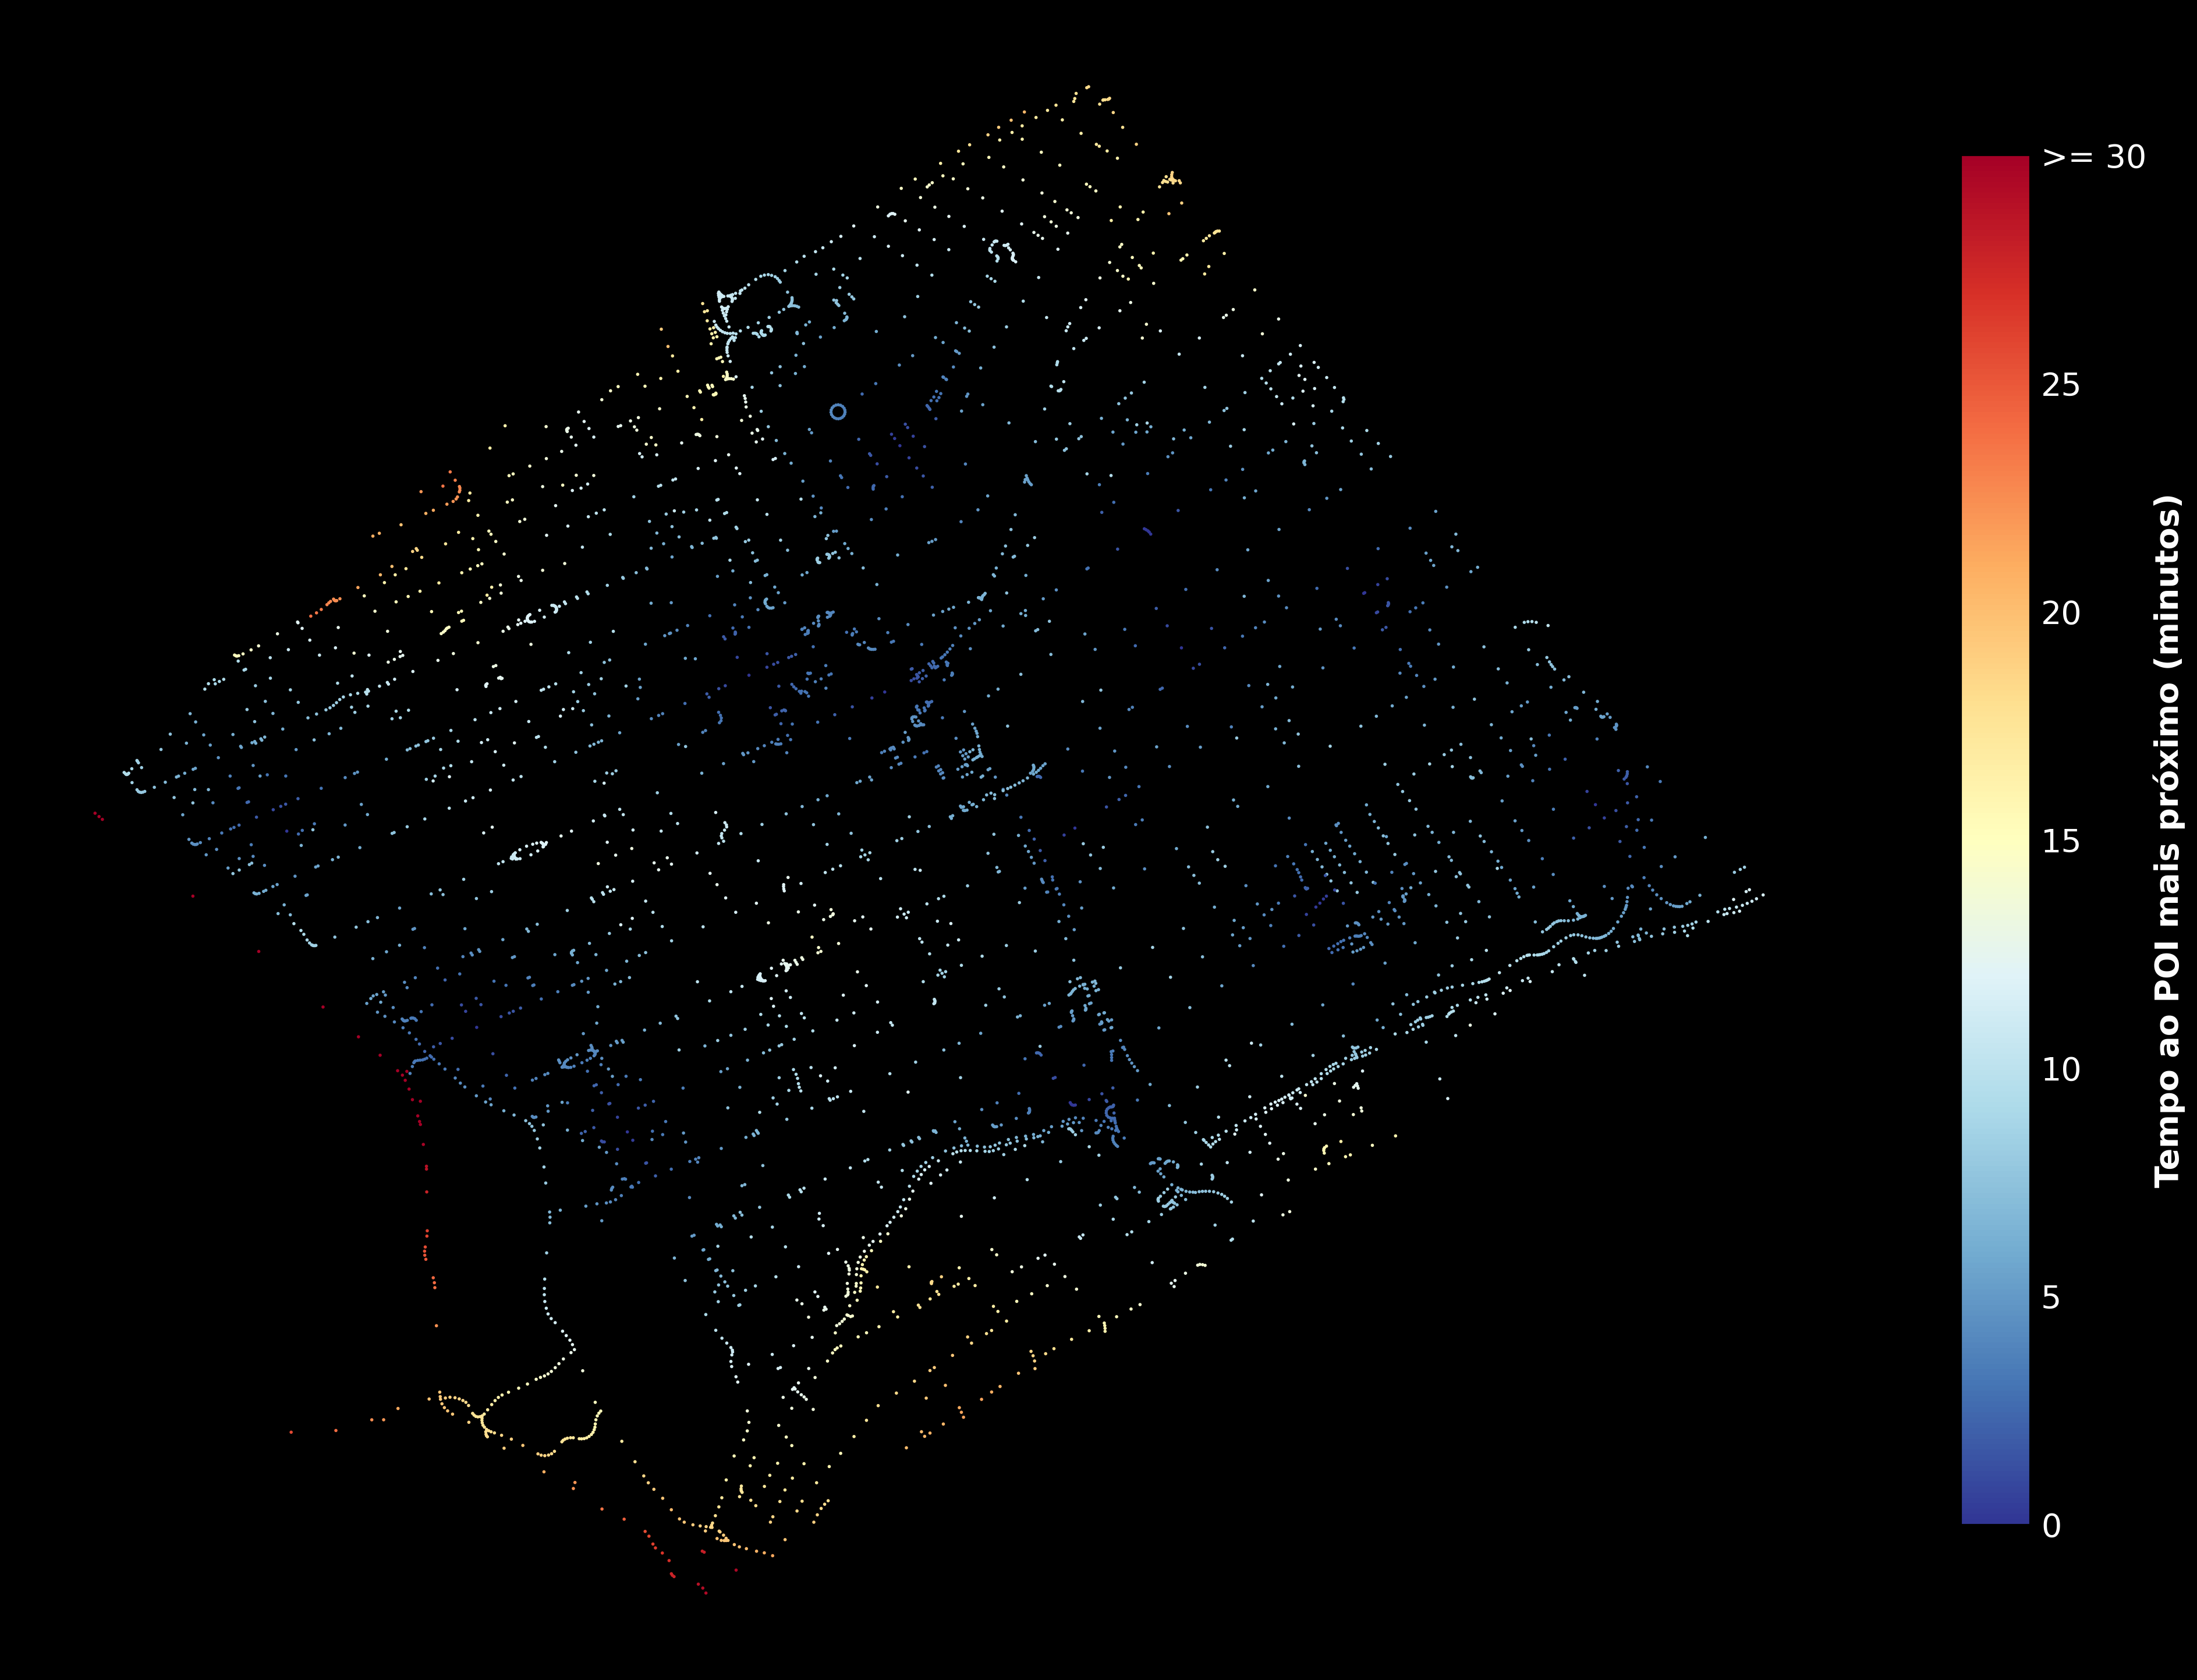

In [159]:
# Set text parameters
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# Setup plot
fig, ax = plt.subplots(figsize=(20,15))
ax.set_axis_off()
ax.set_aspect('equal')
fig.set_facecolor((0,0,0))

# Plot distance to nearest POI
sc = ax.scatter(
    x=nodes['x'],
    y=nodes['y'], 
    c=distances[1],
    s=1,
    cmap='RdYlBu_r',
)

# Colorbar
def ranged_labels(max_val, min_val=0, step=5):
    labels = [
        v for v in range(min_val, max_val, step)
        ]
    if not labels or labels[-1] < max_val:
        labels.append(max_val)

    return labels


def format_labels(nums):
    return [str(n) for n in nums[:-1]] + [f'>= {nums[-1]}'] if nums else []
    

cb = fig.colorbar(
    sc, ax=ax, shrink=0.8,
    ticks=[
        t * 60 # Dados em segundos, tempo máx. viagem, minutos
        for t
        in ranged_labels(tempo_maximo_viagem)
        ]
    )
cb.ax.tick_params(color='none', labelsize=20)
cb.ax.set_yticklabels(
    format_labels(
        ranged_labels(tempo_maximo_viagem)
        )
    )
cb.set_label('Tempo ao POI mais próximo (minutos)', fontsize=20, fontweight='bold')

# Remove empty space
plt.tight_layout()

plt.show()

## Gráficos